# The PhotoBook Dialogue Data

This notebook shows how to import the PhotoBook dataset into our common format. (Or, actually, just into pandas dataframes.)

PhotoBook references:
- [on github](https://dmg-photobook.github.io/index.html)
- [the ACL 2019 paper, Haber et al.](https://www.aclweb.org/anthology/P19-1184/)

In [1]:
from __future__ import division
import codecs
import json
import configparser
import os
import sys

from collections import defaultdict, Counter

from time import localtime, strftime

from textwrap import wrap


import pandas as pd
import numpy as np
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../../clp-vision/Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = configparser.ConfigParser()
with open(config_path, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')

dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')
sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, get_image_filename

In [3]:
pb_base = corpora_base + '/PhotoBook'

In [4]:
logs = []
for root, _, files in os.walk(pb_base + '/logs'):
    for file in files:
        with open(os.path.join(root, file), 'r') as f:
            this_log = json.load(f)
            if len(this_log['rounds']) == 5:
                logs.append(this_log)

In [5]:
def user_styler(r, colmap):
    return ['color: {}'.format(colmap[r['speaker']]) for _ in range(len(r))]

def get_colmap(df):
    users = df['speaker'].unique().tolist()
    colmap = dict(zip(users, 'blue black'.split()))
    return colmap

def pp(df, width=50, textcol='message'):
    out_cols = []
    for this_col in df.columns:
        textcols = [textcol] if type(textcol) is not list else textcol
        if this_col in textcols:
            out_cols.append(df[this_col]
                            .apply(lambda x: 'XXBREAKHEREXX'.join(wrap(x, width))))
        else:
            out_cols.append(df[this_col])

    display(HTML(pd.concat(out_cols, axis=1)
                 .style.apply(lambda x:
                              user_styler(x,
                                          get_colmap(df)),
                              axis=1)
                 .render()
                 .replace("XXBREAKHEREXX", "<br/>")))

In [6]:
def pp_this_round(logs, dial, nround):
    trdf = pd.DataFrame(logs[dial]['rounds'][nround]['messages'])
    trdf = trdf['timestamp message speaker'.split()]
    trdf['message'] = trdf['message'].str.replace(r'<selection> <(.+)>', r'**\1**')
    trdf['timestamp'] = pd.to_timedelta(trdf['timestamp'])
    trdf['timestamp'] = ['{:02}:{:02}'.format(minutes, secs) for minutes, secs in trdf['timestamp'].abs().dt.components['minutes seconds'.split()].values]
    display(pp(trdf))
    return True

In [7]:
def extract_imageid(longform):
    return int(longform.split('/')[1].split('_')[2].split('.')[0])

In [8]:
def show_user_view(logs, dial, nround, this_player):
    this_round = logs[dial]['rounds'][nround]
    n_rows = 2
    n_cols = 3
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 5))
    fig.subplots_adjust(hspace=0, wspace=0)
    highlighted = this_round['highlighted'][this_player]
    for n, image in enumerate(this_round['images'][this_player]):
        this_img = plt.imread(get_image_filename(config, icorpus_code['mscoco'], extract_imageid(image)))
        this_ax = ax[n // n_cols, n % n_cols]
        this_ax.imshow(this_img)
        this_ax.axis('off')
        if highlighted[n]:
            this_ax.add_patch(matplotlib.patches.Rectangle(
                (0, 0), this_img.shape[1], this_img.shape[0],
                edgecolor='red',
                fill=False, linewidth=4
                )
                             )



In [9]:
this_dial = 10

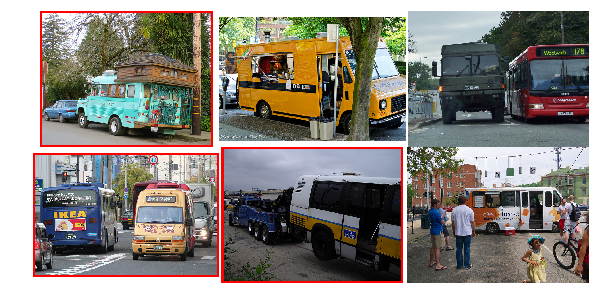

In [10]:
show_user_view(logs, this_dial, 0, 'A')

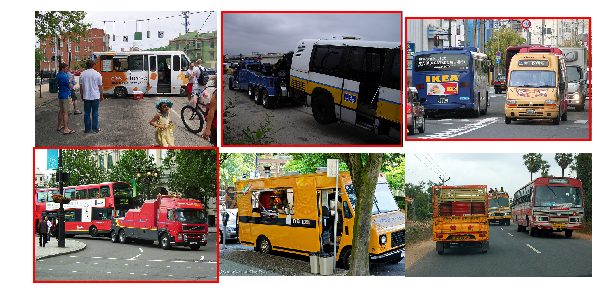

In [11]:
show_user_view(logs, this_dial, 0, 'B')

In [12]:
pp_this_round(logs, this_dial, 0)

None

True

-------------------- Round 1 --------------------
A's view


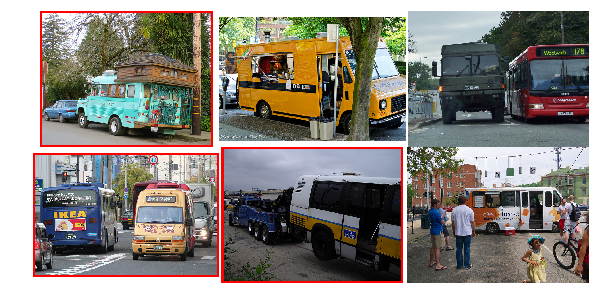

B's view


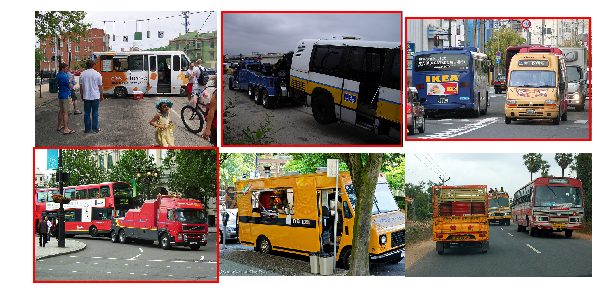

None

True

-------------------- Round 2 --------------------
A's view


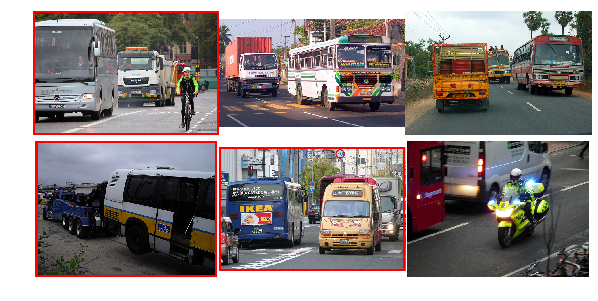

B's view


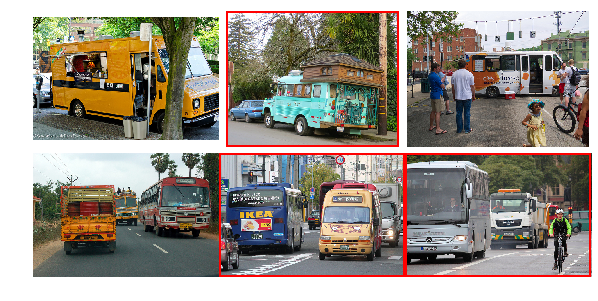

None

True

-------------------- Round 3 --------------------
A's view


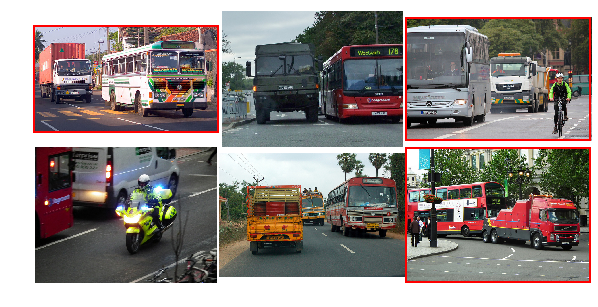

B's view


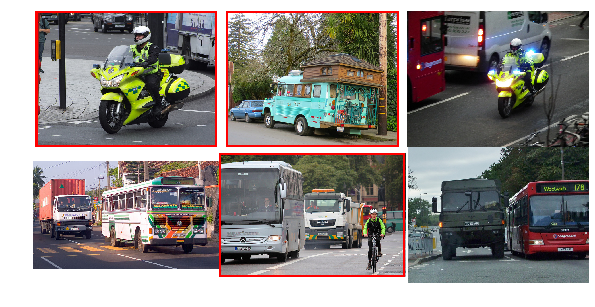

None

True

-------------------- Round 4 --------------------
A's view


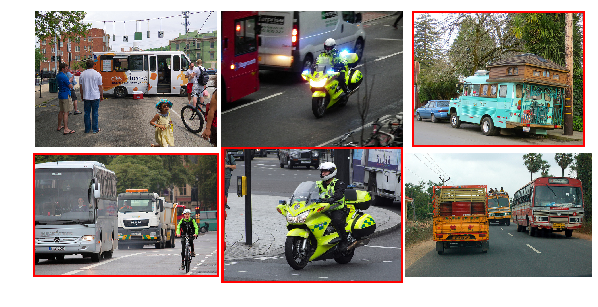

B's view


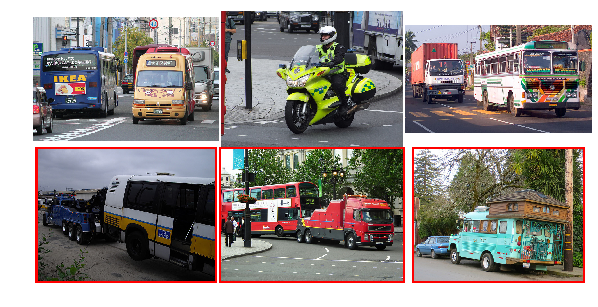

None

True

-------------------- Round 5 --------------------
A's view


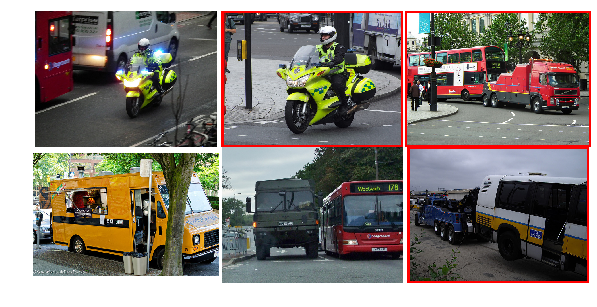

B's view


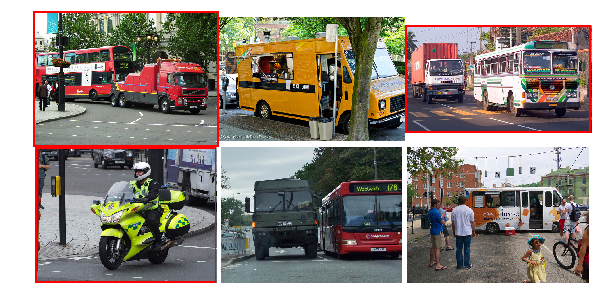

None

True

In [13]:
for n in range(5):
    print('-' * 20, 'Round', n+1, '-' * 20)
    print("A's view")
    show_user_view(logs, this_dial, n, 'A')
    plt.show()
    print("B's view")
    show_user_view(logs, this_dial, n, 'B')
    plt.show()
    display(pp_this_round(logs, this_dial, n))